## Bitcoin Fear & Greed Index
***

### Introduction
***
This is an attempt to create a sentiment index for Bitcoin. This sentiment index can be used for the purpose of trading into bitcoins and also as an indicator of overall mood. I have broadly divided the components of this index in two categories as follows.

**Market Sentiment**
 - Momentum
 - Price / MA
 - Implied Volatility (VIX)
 - Simulated Price (using Geometric Brownian Motion)
 
**Social Sentiment**
 - Google search trend
 - News articles
 - Reddit posts

### Methoodology
***

Data points that are used for creating this index are from 1 May 2018 to 31 May 2018. This project is only for PoC purpose. The limitation of the dataset is majorly due to non availability of historical social sentiment data with free api's. The methodology used to compute various factors is stated below.

- **Momentum**: Momentum is calculated as
$$momentum = \frac{90dEMA - 30dEMA}{90dEMA}$$


- **Implied Volatility**: Volatility Index is calculated using forecasted volatility using GARCH(1,1) model. Forecast for next 24 periods of volatility is made and calculated as $$\left ( \frac{VIX_t}{100} \right )^2 = \frac{1}{n}\sum_{k=1}^{n}E_{t}^{Q}\left [ \tilde{h}_{t+\frac{\tau_0 k}{n}} \right ]$$

  Refrence: Hao, J., & Zhang, J. E. (2013). GARCH option pricing models, the CBOE VIX, and variance risk premium. Journal of Financial Econometrics, 11(3), 556-580.


- **Price / 125d MA**


- **Google Search Trend**: Interest over time from google trends for the keyword 'bitcoin'


- **News**: Sentiment analysis using vaderSentiment api of news articles with 'bitcoin' keyword in their title


- **Reddit**: Top posts titles in subreddit r/bitcoin are captured and sentiment analysis using vaderSentiment is performed


In [40]:
import numpy as np
import pandas as pd
import glob
import json
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore")

## Data cleaning and resampling

 - Original bitcoin price data is of 30min frequency, but needs to be resampled to 60min frequency as the social sentiment data is only available at 60min frequency
 - Series is extracted for a period more than required so as to factor in for moving averages

In [48]:
df = pd.read_csv('./data/bitcoin.csv', sep = '\t')
df.Timestamp = pd.to_datetime(df.Timestamp) # convert timestamp to datetime format
df.replace(to_replace='—', value = '', inplace=True) # replace - values with blanks
df.set_index(df.Timestamp,drop=True,inplace=True) # set timestamp as index
df.drop(labels = 'Timestamp', axis = 1, inplace=True) # drop timestamp column

# convert data to numeric
df[['Open','High','Low','Volume (BTC)','Volume (Currency)','Weighted Price','Close']] = df[['Open','High','Low','Volume (BTC)','Volume (Currency)','Weighted Price','Close']].apply(pd.to_numeric)

df.fillna(method='ffill',inplace=True) # forward fill na values
df.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Timestamp,,,,,,,
2012-12-31 00:00:00,13.2,13.2,13.20,13.20,0.23,3.04,13.20
2012-12-31 00:30:00,13.2,13.2,13.20,13.20,0.23,3.04,13.20
2012-12-31 01:00:00,13.2,13.2,13.18,13.18,2.28,30.05,13.18
2012-12-31 01:30:00,13.2,13.2,13.20,13.20,23.00,303.60,13.20
2012-12-31 02:00:00,13.2,13.2,13.20,13.20,23.00,303.60,13.20


Text(0.5,1,'Bitcoin Prices')

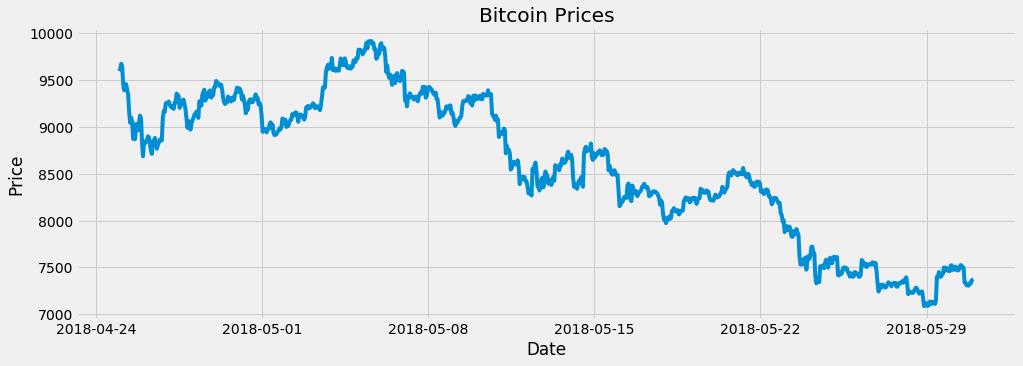

In [61]:
# ectracting the data as required, additional 125 periods are added in begining to account for moving average
df2 = df.ix[datetime.date(year=2018,month=4,day=25):datetime.date(year=2018,month=5,day=31)].copy()

# resample the dataframe to a 60min frequency
dfh  = pd.DataFrame()
dfh['open'] = df2.Open.resample('60Min', base = 30).last()
dfh['high'] = df2.High.resample('60Min', base = 30).last()
dfh['low'] = df2.Low.resample('60Min', base = 30).last()
dfh['close'] = df2.Close.resample('60Min', base = 30).last()
dfh['volume_btc'] = df2['Volume (BTC)'].resample('60Min', base = 30).last()
dfh['volume_currency'] = df2['Volume (Currency)'].resample('60Min', base = 30).last()
dfh['wtd_price'] = df2['Weighted Price'].resample('60Min', base = 30).last()

# plot the bitcoin close price time series
plt.figure(figsize=(15,5))
plt.plot(dfh.index, dfh.close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Prices')

## Momentum indicator

In [62]:
dfh['90dema'] = pd.Series.ewm(dfh['close'], span=90, min_periods=90).mean()
dfh['30dema'] = pd.Series.ewm(dfh['close'], span=30, min_periods=30).mean()
dfh['mom'] = (dfh['90dema'] - dfh['30dema'])/dfh['90dema']


dfh['mom45mean'] = dfh['mom'].rolling(45, min_periods=45).mean()
dfh['mom45sigma'] = dfh['mom'].rolling(45, min_periods=45).std()
dfh['momfinal'] = abs(dfh['mom45mean'] - dfh['mom'])/dfh['mom45sigma']

dfh.drop(labels = ['90dema','30dema','mom','mom45mean','mom45sigma'], inplace=True, axis=1)

## Price / MA125 indicator

In [64]:
dfh['ma125'] = dfh['close'].rolling(125, min_periods=125).mean()
dfh['pricema'] = dfh['close'] / dfh['ma125']

dfh['pricemamean'] = dfh['pricema'].rolling(45,min_periods=45).mean()
dfh['pricemasigma'] = dfh['pricema'].rolling(45,min_periods=45).std()
dfh['pricemafinal'] = abs(dfh['pricemamean'] - dfh['pricema'])/dfh['pricemasigma']

dfh.drop(labels = ['ma125','pricema','pricemamean','pricemasigma'], inplace=True, axis=1)

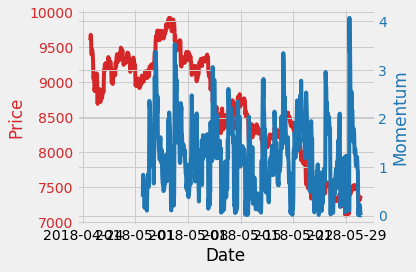

In [60]:
fig,ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(dfh.index, dfh.close, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Momentum', color=color)  # we already handled the x-label with ax1
ax2.plot(dfh.index, dfh.pricemafinal, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## News sentiment analysis

In [52]:
# get list of all files in the news data folder
files = glob.glob("/home/cchopade/crypto_hackathon/data/news/*.txt")

# initialize vaderSentiment object
analyzer = SentimentIntensityAnalyzer()

# create empty dataframe to store data
news_data = pd.DataFrame(columns = ['published','title','text','neg','neu','pos','compound'])

# loop through each file, parse text, perform sentiment analysis and store to dataframe
for file in files:
    with open(file) as json_file:  
        data = json.load(json_file)


    # create a blank dictionary to convert the data in a pandas dataframe
    news_dict = { "published":[],
                    "title":[],
                    "text":[], "neg":[],
                    "neu": [],
                    "pos": [],
                    "compound":[]}

    for news in data['posts']:
        news_dict["published"].append(news['published'])
        news_dict["title"].append(news['title'])
        news_dict["text"].append(news['text'])
        vs = analyzer.polarity_scores(news['text'])
        news_dict["neg"].append(vs['neg'])
        news_dict["neu"].append(vs['neu'])
        news_dict["pos"].append(vs['pos'])
        news_dict["compound"].append(vs['compound'])

    
    news_data = news_data.append(pd.DataFrame(news_dict),ignore_index=True)

news_data.to_csv('data/news_analysis.csv') # save processed data to csv for future use

/home/cchopade/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [42]:
# get list of all files in the news data folder
files = glob.glob("/home/cchopade/crypto_hackathon/data/google_news/*.txt")

# initialize vaderSentiment object
analyzer = SentimentIntensityAnalyzer()

# create empty dataframe to store data
news_data = pd.DataFrame(columns = ['published','title','text','neg','neu','pos','compound'])

# loop through each file, parse text, perform sentiment analysis and store to dataframe
for file in files:
    with open(file) as json_file:  
        data = json.load(json_file)


    # create a blank dictionary to convert the data in a pandas dataframe
    news_dict = { "published":[],
                    "title":[],
                    "text":[], "neg":[],
                    "neu": [],
                    "pos": [],
                    "compound":[]}

    for news in data['articles']:
        news_dict["published"].append(news['publishedAt'])
        news_dict["title"].append(news['title'])
        news_dict["text"].append(news['description'])
        if news['description'] == None:
            vs = analyzer.polarity_scores(news['title'])
        else:
            vs = analyzer.polarity_scores(news['description'])
        news_dict["neg"].append(vs['neg'])
        news_dict["neu"].append(vs['neu'])
        news_dict["pos"].append(vs['pos'])
        news_dict["compound"].append(vs['compound'])

    
    news_data = news_data.append(pd.DataFrame(news_dict),ignore_index=True)

news_data.to_csv('data/google_news_analysis.csv') # save processed data to csv for future use